In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import six

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, Concatenate, MaxPooling2D
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import Input, Dropout, BatchNormalization

from tqdm import tqdm_notebook

from keras import Model
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K


# from keras.engine.topology import Input
# from keras.engine.training import Model
# from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
# from keras.layers.core import Activation, SpatialDropout2D
# from keras.layers.merge import concatenate,add
# from keras.layers.normalization import BatchNormalization
# from keras.layers.pooling import MaxPooling2D

2024-03-21 01:04:19.067500: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 01:04:20.010701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("GPU Available" if len(tf.config.list_physical_devices('GPU')) > 0 else "GPU Not Detected")

GPU Available


2024-03-21 01:04:35.221499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 01:04:35.517906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 01:04:35.518126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
from os import listdir

image_path = './data/images_cut/'
labels_path = './data/labels_cut/'

file_names = [filename for filename in listdir(image_path)]
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)

train_image_path = [image_path + file_name for file_name in train_files]
train_mask_path = [labels_path + file_name for file_name in train_files]

eval_image_path = [image_path + file_name for file_name in val_files]
eval_mask_path = [labels_path + file_name for file_name in val_files]

In [12]:

train_df = pd.DataFrame({'image_path': train_image_path, 'mask_path': train_mask_path})

train_df["image"] = [np.array(load_img(path)) / 255 for path in train_df["image_path"]]
train_df["mask"] = [np.array(load_img(path)) / 255 for path in train_df["mask_path"]]

eval_df = pd.DataFrame({'image_path': eval_image_path, 'mask_path': eval_image_path})

eval_df["image"] = [np.array(load_img(path)) / 255 for path in eval_df["image_path"]]
eval_df["mask"] = [np.array(load_img(path)) / 255 for path in eval_df["mask_path"]]

train_df.iloc[0].mask

<bound method NDFrame.mask of image_path                            ./data/images_cut/822.png
mask_path                             ./data/labels_cut/822.png
image         [[[0.3686274509803922, 0.3686274509803922, 0.3...
mask          [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
Name: 0, dtype: object>

In [9]:
import matplotlib.pyplot as plt

def display_img(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis("off")
 plt.show()

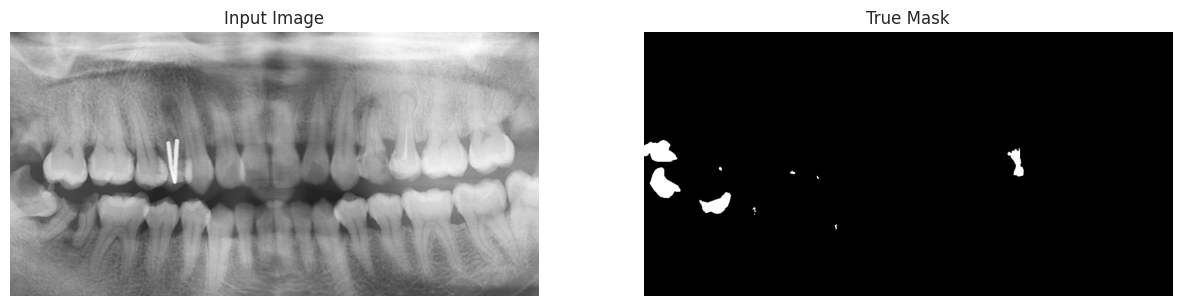

In [13]:
display_img([train_df.iloc[0].image, np.array(load_img(train_df.iloc[0].mask_path)) / 255])

In [ ]:
class DataSet():
    def __init__(self, images_paths, labels_paths):
        